### CONFIGURATION

In [64]:
import os
import pandas as pd
import venn as vn
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 200)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#PYFAIDX
from pyfaidx import Fasta
genes = Fasta('/Users/peterpriestley/hmf/data/refgenomes/Homo_sapiens.GRCh37.GATK.illumina/Homo_sapiens.GRCh37.GATK.illumina.fasta')

In [3]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [4]:
#VCF
VCF_PATH = "/Users/peterpriestley/hmf/analyses/170117_PMC_analysis/"

# BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
#BED_FILE_NAME = "cosmicCancerCensus.bed" 
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_NON_BED_MUTATIONS = True

# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [5]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [6]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','PONCount']
    return dfPON

In [13]:
# SPECIFY SAMPLES
VCF_SAMPLES=[]
for x in os.listdir(VCF_PATH):
    #if x[-10:] == "sliced.vcf":
    #    VCF_SAMPLES.append(x[40:52] + "R_" + x[40:52] + "T_merged_somatics_snpEff_dbSNP_Cosmicv76_melted.vcf")
    if x[-10:] == "melted.vcf":
        VCF_SAMPLES.append(x)

#VCF_SAMPLES=['CPCT02010299R_CPCT02010299T_merged_somatics_snpEff_dbSNP_Cosmicv76_melted.vcf']
#VCF_SAMPLES = ['CPCT02010384R_CPCT02010384T_merged_somatics_snpEff_dbSNP_Cosmicv76_melted.vcf']
print VCF_SAMPLES

['PMC010001R_PMC010001T_merged_somatics_annotated_melted.vcf', 'PMC010001R_PMC010001TII_merged_somatics_annotated_melted.vcf', 'PMC010001R_PMC010001TIII_merged_somatics_annotated_melted.vcf']


<h3> LOAD VCF

In [17]:
for VCF_SAMPLE in VCF_SAMPLES:
        print {VCF_SAMPLE[11:len(VCF_SAMPLE)-37]:'melted'}

{'PMC010001T': 'melted'}
{'PMC010001TII': 'melted'}
{'PMC010001TIII': 'melted'}


In [26]:
#Load all VCF_SAMPLES to DF
df = pd.DataFrame({})
for VCF_SAMPLE in VCF_SAMPLES:
    VCF_FILE_NAME = VCF_SAMPLE
    SAMPLE_NAMES = {VCF_SAMPLE[11:len(VCF_SAMPLE)-37]:'melted'}
    #SAMPLE_NAMES = {"/sample/output/160604_HMFreg0056_FR10302029_FR10302030_CPCT02010299/somaticVariants/CPCT02010299R_CPCT02010299T/CPCT02010299R_CPCT02010299T_merged_somatics_snpEff_dbSNP_Cosmicv76":'melted'}
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE[11:len(VCF_SAMPLE)-37],True,True,bed,LOAD_NON_BED_MUTATIONS)])
    else:
        df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE[11:len(VCF_SAMPLE)-37],True)])

reading vcf file: PMC010001R_PMC010001T_merged_somatics_annotated_melted.vcf
Number variants loaded: 40420
reading vcf file: PMC010001R_PMC010001TII_merged_somatics_annotated_melted.vcf
Number variants loaded: 40149
reading vcf file: PMC010001R_PMC010001TIII_merged_somatics_annotated_melted.vcf
Number variants loaded: 41949


In [27]:
df = loadHealthChecksAndMerge(df)

### PON FILTERING

In [92]:
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/","PON.tsv")

In [93]:
#del df['PONCount']
#del df['inPON']

In [94]:
df = pd.merge(df,dfPON,how='left', on=['chrom','pos'])
df['PONCount'].fillna(0, inplace=True)
df['inPON'] = df.PONCount>0

In [53]:
pd.pivot_table(df[df.consensus==True], values='pos', index=['patientName'], columns=['variantType','inPON'], aggfunc='count',margins=False).fillna("")

variantType   INDEL         SNP      
inPON         False True  False True 
patientName                          
PMC010001T      354   619   399  1343
PMC010001TII    350   603   474  1335
PMC010001TIII   298   504   591   919

<h3> High Level Stats

In [ ]:
dftemp = df[(df['inDBSNP']==False)]#&(df['tumorSGT']<>"1/1")]
#Alllele Freq By Caller
for columnName in list(dftemp):
    if columnName.endswith('AF'):
        ser = dftemp[columnName]
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-2]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6])

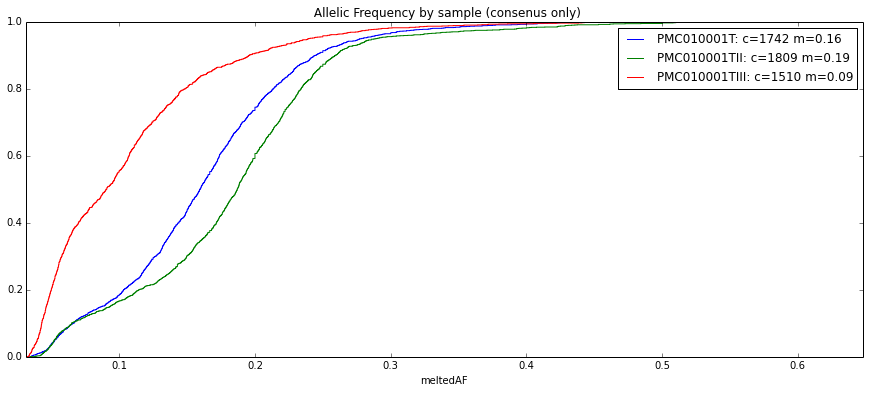

In [101]:
dftemp = df[(df['variantType']=='SNP')&(df['consensus']==True)]#&(df['tumorSGT']<>"1/1")]
#Alllele Freq By Patient Name
patientNames = dftemp.patientName.unique()
for patientName in patientNames:
    ser = dftemp[(dftemp.patientName==patientName)]['meltedAF']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=patientName+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by sample (consenus only)",figsize=[15,6])

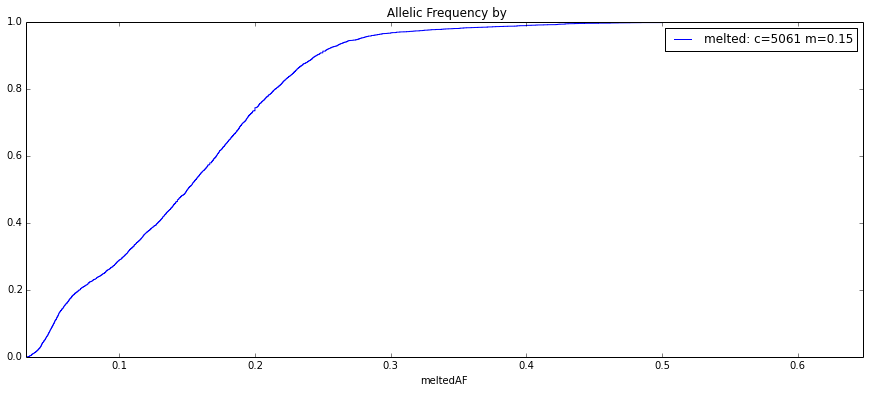

In [43]:
dftemp = df[(df['consensus']==True)&(df['variantType']=='SNP')]#&(df['tumorSGT']<>"1/1")]
#Alllele Freq By Caller
for columnName in list(dftemp):
    if columnName.endswith('AF'):
        ser = dftemp[columnName]
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-2]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6])

### HIGH and MODERATE impact NON-missense

In [58]:
pd.pivot_table(df, values='pos', index=['chromPos','patientName','TUMOR_TYPE','annGene','annWorstImpact','annWorstEffect','consensus','meltedAF'], columns=['inCOSMIC'], aggfunc='count',margins=True).fillna("")

inCOSMIC                                                                                                                                False True       All
chromPos     patientName   TUMOR_TYPE annGene       annWorstImpact annWorstEffect                           consensus meltedAF                              
10:10001794  PMC010001TII  Unknown                                                                          False     0.338028169014        1            1.0
10:10001801  PMC010001TII  Unknown                                                                          False     0.323943661972        1            1.0
10:10001802  PMC010001TII  Unknown                                                                          False     0.323943661972        1            1.0
10:1001023   PMC010001T    Unknown                                                                          False     0.0875                1            1.0
             PMC010001TIII Unknown                                                                          False     0.0804597701149       1            1.0
10:100114992 PMC010001TIII Unknown                                                                          True      0.062015503876        1            1.0
10:100161771 PMC010001TIII Unknown    PYROXD2       MODIFIER       intron_variant                           True      0.0584795321637       1            1.0
10:100202276 PMC010001TIII Unknown    HPS1          MODIFIER       intron_variant                           False     0.225806451613        1            1.0
10:100217502 PMC010001T    Unknown                                                                          False     0.0833333333333       1            1.0
10:100320921 PMC010001TII  Unknown    HPSE2         MODIFIER       intron_variant                           False     0.0454545454545       1            1.0
             PMC010001TIII Unknown    HPSE2         MODIFIER       intron_variant                           False     0.0593220338983       1            1.0
10:100397894 PMC010001TIII Unknown    HPSE2         MODIFIER       intron_variant                           False     0.214285714286        1            1.0
10:10047562  PMC010001TII  Unknown                                                                          False     0.292929292929        1            1.0
             PMC010001TIII Unknown                                                                          False     0.319672131148        1            1.0
10:10047575  PMC010001T    Unknown                                                                          True      0.185714285714        1            1.0
             PMC010001TII  Unknown                                                                          True      0.198347107438        1            1.0
             PMC010001TIII Unknown                                                                          True      0.260869565217        1            1.0
10:10047590  PMC010001T    Unknown                                                                          True      0.169014084507        1            1.0
             PMC010001TII  Unknown                                                                          True      0.177419354839        1            1.0
             PMC010001TIII Unknown                                                                          True      0.212765957447        1            1.0
10:100495007 PMC010001T    Unknown    HPSE2         MODIFIER       intron_variant                           False     0.125                 1            1.0
             PMC010001TII  Unknown    HPSE2         MODIFIER       intron_variant                           False     0.241379310345        1            1.0
             PMC010001TIII Unknown    HPSE2         MODIFIER       intron_variant                           False     0.161290322581        1            1.0
10:100543473 PMC010001TII  Unknown    HPSE2         MODIFIER       intron_v

### Missense

In [18]:
df[(df.annAllEffects.str.contains("missense"))&(df.numCallers==2)]

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,patientName
18474,3,195507604,3:195507604,3.987300,rs200566410;COSM4591072,C,varscan-mutect,2,SNP,,PASS,,True,True,MUC4,MODERATE,missense_variant,missense_variant|missense_variant|sequence_fea...,False,G,0.169231,66,-1.0,0/1,,CPCT02010299
32973,9,134151559,9:134151559,9.949991,.,C,strelka-mutect,2,SNP,,PASS,Default,False,False,FAM78A,MODERATE,missense_variant,missense_variant,True,A,0.037037,136,-1.0,0/1,,CPCT02010299
55307,14,105414878,14:105414878,14.981978,rs201870387,T,strelka-varscan,2,SNP,,PASS,,True,False,AHNAK2,MODERATE,missense_variant,missense_variant|intron_variant|non_coding_exo...,False,G,0.114754,61,-1.0,0/1,,CPCT02010299
55708,15,22743484,15:22743484,15.221820,.,T,strelka-varscan,2,SNP,,PASS,,False,False,GOLGA6L1,MODERATE,missense_variant,missense_variant|missense_variant,False,G,0.107143,118,-1.0,0/1,,CPCT02010299
74298,21,46918360,21:46918360,21.974828,.,G,strelka-varscan,2,SNP,,PASS,,False,False,SLC19A1,MODERATE,missense_variant,missense_variant|missense_variant|sequence_fea...,False,C,0.140187,111,-1.0,0/1,,CPCT02010299
74300,21,46918387,21:46918387,21.974828,COSM2821903,G,strelka-varscan,2,SNP,,PASS,,False,True,SLC19A1,MODERATE,missense_variant,missense_variant|missense_variant|sequence_fea...,False,T,0.149533,110,-1.0,0/1,,CPCT02010299
77989,X,19418704,X:19418704,23.125064,.,T,strelka-mutect,2,SNP,,PASS,Default,False,False,MAP3K15,MODERATE,missense_variant,missense_variant|missense_variant|missense_var...,True,C,0.893939,67,-1.0,0/1,,CPCT02010299
83222,MT,6757,MT:6757,25.407761,.,T,strelka-varscan,2,SNP,,PASS,,False,False,MT-CO1,MODERATE,missense_variant,missense_variant|sequence_feature,False,C,0.670349,4073,-1.0,0/1,,CPCT02010299


In [11]:
pd.pivot_table(df[(df.annAllEffects.str.contains("missense"))], values='pos', index=['variantType','numCallers'], columns=['consensus','inDBSNP','bedRegion'], aggfunc='count',margins=True).fillna("")

consensus              False                       True            All
inDBSNP                False         True         False               
bedRegion                    Default      Default       Default       
variantType numCallers                                                
SNP         1             68      34   37       1                140.0
            2              6            6                     2   14.0
            3                                         4       2    6.0
            4                                         5      20   25.0
All                       74      34   43       1     9      24  185.0

In [13]:
pd.pivot_table(df[(df.annAllEffects.str.contains("missense"))], values='pos', index=['variantType','numCallers'], columns=['consensus','inDBSNP','bedRegion'], aggfunc='count',margins=True).fillna("")

consensus              False                       True                    All
inDBSNP                False         True         False            True       
bedRegion                    Default      Default       Default Default       
variantType numCallers                                                        
SNP         1             74      50   50       6                        180.0
            2             18            7       4           123       3  155.0
            3                                        19     122      13  154.0
            4                                         3      22           25.0
All                       92      50   57      10    22     267      16  514.0

In [ ]:
len(df[(df.annAllEffects.str.contains("missense"))&(df.bedRegion <> '')])

### Consensus

In [ ]:
pd.pivot_table(df, values='pos', index=['variantType','numCallers'], columns=['consensus','inDBSNP','bedRegion'], aggfunc='count',margins=True).fillna("")

### Mutational Patterns

In [ ]:
pd.pivot_table(df[(df.ref.str.len()==1)&(df.variantType == 'SNP')], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

In [ ]:
pd.pivot_table(df[df.annAllEffects.str.contains("missense")], values='pos', index=['chromPos','patientName','annGene','meltedAF','numCallers','inCOSMIC'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### SINGLE PATIENT ANALYSIS

In [ ]:
df[(df.patientName=='CPCT02140013')]#[['patientName','TUMOR_TYPE','pos','chrom','id','variantType','ref','meltedallele','meltedDP','meltedAF','vennSegment','annGene']].head(20)

### SCRATCH

In [ ]:
pd.pivot_table(df, values='pos', index=['numCallers','vennSegment'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

In [ ]:
df[df.numCallers ==1]

In [ ]:
def refgenomeContext(chromPos):
    chrom = chromPos.split(':')[0]
    pos = int(chromPos.split(':')[1])
    try:
        return str(genes[chrom][pos-2:pos+1][:3])
    except TypeError:
        return -1

In [ ]:
str(genes[7][467652-2:467652+1][:3])

In [ ]:
refgenomeContext('7:467652')

In [ ]:
df['refTriplet'] =df['chromPos'].apply(lambda x: refgenomeContext(x))

In [ ]:
df.head(1)

In [ ]:
pd.pivot_table(df[df.variantType=='SNP'], values='pos', index=['refTriplet','meltedallele'], columns=['inDBSNP'], aggfunc='count',margins=True).fillna("").sort_values('All',ascending=False)

In [ ]:
### VENN

In [60]:
df.head(1)

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,patientName,TUMOR_PERCENTAGE,TUMOR_TYPE,PIPELINE_VERSION,PONCount,inPON
0,1,14741,1:14741,1.000059,.,C,mutect,1,SNP,,PASS,,False,False,WASH7P,MODIFIER,intron_variant,intron_variant|intron_variant|non_coding_exon_...,False,A,0.038922,334,-1.0,0/1,,PMC010001T,Unknown,Unknown,Unknown,0,False


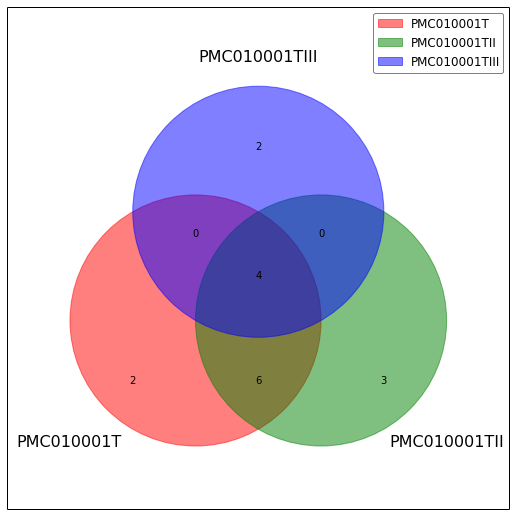

In [100]:
dftemp = df[(df.consensus== True)&(df.variantType == "SNP")&(df.annAllEffects.str.contains('missense'))&(df.inPON==False)]
vn.venn([dftemp[dftemp.patientName == 'PMC010001T']['chromPos'],dftemp[dftemp.patientName == 'PMC010001TII']['chromPos'], \
        dftemp[dftemp.patientName == 'PMC010001TIII']['chromPos']],['PMC010001T','PMC010001TII','PMC010001TIII'],figsize=(9,9))

### Common mutations

In [95]:
len(df)

6744267

In [90]:
# Calls with more than 1 instance
dfTemp = df[['consensus','inPON','numCallers','vennSegment','variantType','chrom','pos','bedRegion','annGene','annWorstEffect','chromPos','id']].groupby(['inPON','consensus','numCallers','vennSegment','variantType','chrom','pos','bedRegion','annGene','annWorstEffect','id']).agg('count').sort_values('chromPos',ascending=False)
dfTemp = dfTemp[dfTemp.chromPos>1]
len(dfTemp)

709143

In [ ]:
#dfTemp = pd.pivot_table(df[(df.bedRegion=='Default')], values='chromPos', index=['chrom','pos','annGene','annWorstEffect','id'], columns=['bedRegion'], aggfunc='count',margins=True).fillna("")
#dfTemp = dfTemp[dfTemp.All>1].sort_values('All',ascending=False)
#len(dfTemp)

In [91]:
dfTemp = dfTemp.reset_index()

In [96]:
dfTemp[(dfTemp.consensus==False)][['inPON','variantType','numCallers','chromPos']].groupby(['inPON','variantType','numCallers']).agg('count')  #.reset_index().sort_values('numCallers',ascending=False)

chromPos
inPON variantType numCallers          
False INDEL       1              80151
      SNP         1             377144
                  2              10537
True  INDEL       1              93410
      SNP         1             114946
                  2               5542

In [ ]:
dfTemp
dfTemp.groupby(['TUMOR_TYPE']).agg('count')['patientName']

In [ ]:
#temp.reset_index
#groupby(['bedRegion']).agg('count')

In [ ]:
temp.sort_values('All',ascending=False)

In [ ]:
pd.pivot_table(df, values='pos', index=['annWorstEffect'], columns=['consensus'], aggfunc='count',margins=True).fillna("")